# Data exploration

In [74]:
import pandas as pd

import re

import numpy as np

np.random.seed(4)

import string

pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns',50)
pd.set_option('display.width',5000)
pd.set_option('max_colwidth', 500)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import gensim
from gensim.parsing.preprocessing import STOPWORDS

In [2]:
data = pd.read_csv('twcs.csv', sep = ',')

In [3]:
data.shape

(2811774, 7)

In [4]:
data.head(10)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,"@115712 Can you please send us a private message, so that I can gain further details about your account?","5,7",8.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
7,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,"@115713 This is saddening to hear. Please shoot us a DM, so that we can look into this for you. -KC",NaN,12.0
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯,"11,13,14",15.0
9,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,"@115713 We understand your concerns and we'd like for you to please send us a Direct Message, so that we can further assist you. -AA",12,16.0


**Columns - descriptions from Kaggle**

tweet_id -unique, anonymized ID for the tweet → index

author_id - unique, anonymized user ID (if author is company than user ID is not anonymized!) → separate users from companies  

inbound - whether the tweet is "inbound" to a company doing customer support on Twitter  

created_at - date and time when the tweet was sent  → not neccessary

text - tweet content 

response_tweet_id - IDs of tweets that are responses to this tweet, comma-separated  → used to connect conversations

in_response_to_tweet_id - ID of the tweet this tweet is in response to, if any  → used to connect conversations


In [5]:
data.dtypes

tweet_id                     int64
author_id                   object
inbound                       bool
created_at                  object
text                        object
response_tweet_id           object
in_response_to_tweet_id    float64
dtype: object

Number of unique authors

In [7]:
data.author_id.nunique()

702777

Number of unique companies (where author ID is not numeric)

In [8]:
data[data.author_id.str.isnumeric() == False].author_id.nunique()

108

In [9]:
print('Number of tweets by users:', data[data.author_id.str.isnumeric() == False].shape[0])
print('Number of tweets by companies:', data[data.author_id.str.isnumeric() == True].shape[0])

Number of tweets by users: 1273931
Number of tweets by companies: 1537843


Most common authors (companies, as expected):

In [10]:
data.author_id.value_counts()[:30]

AmazonHelp         169840
AppleSupport       106860
Uber_Support        56270
SpotifyCares        43265
Delta               42253
Tesco               38573
AmericanAir         36764
TMobileHelp         34317
comcastcares        33031
British_Airways     29361
SouthwestAir        28977
VirginTrains        27817
Ask_Spectrum        25860
XboxSupport         24557
sprintcare          22381
hulu_support        21872
sainsburys          19466
GWRHelp             19364
AskPlayStation      19098
ChipotleTweets      18749
VerizonSupport      17966
UPSHelp             17817
ATVIAssist          17650
O2                  16212
Safaricom_Care      16077
idea_cares          15724
AskTarget           13218
AirAsiaSupport      12829
BofA_Help           12683
SW_Help             12231
Name: author_id, dtype: int64

In [17]:
data[data.author_id.str.isnumeric() == False].author_id.value_counts().tail(10) # some companies are very rare

MOO                630
ask_progressive    612
KeyBank_Help       555
AskRobinhood       432
mediatemplehelp    305
JackBox            266
OfficeSupport      218
AskDSC             210
CarlsJr            196
HotelTonightCX     152
Name: author_id, dtype: int64

Connecting tweets and responses to get ratio of tweets directed to certain companies

In [56]:
first_inbound = data[pd.isnull(data.in_response_to_tweet_id) & data.inbound] #first inbound messages

inbounds_and_outbounds = pd.merge(first_inbound, data, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id') # all tweets in response merged
inbounds_and_outbounds = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]

perc_authors = inbounds_and_outbounds.author_id_y.value_counts().rename_axis('unique_values').to_frame('counts')

perc_authors['Ratio'] = perc_authors.counts / inbounds_and_outbounds.shape[0] * 100

perc_authors['Cum_sum'] = perc_authors.Ratio.cumsum()

In [58]:
perc_authors.head(10)

,counts,Ratio,Cum_sum
unique_values,,,
AmazonHelp,84637,10.655559,10.655559
AppleSupport,74632,9.395958,20.051517
Uber_Support,40029,5.039538,25.091055
Delta,28485,3.586181,28.677236
SpotifyCares,26940,3.391670,32.068906
Tesco,24887,3.133203,35.202109
AmericanAir,24506,3.085236,38.287345
comcastcares,23841,3.001515,41.288860
SouthwestAir,20986,2.642078,43.930938


In [59]:
perc_authors.tail(10)

,counts,Ratio,Cum_sum
unique_values,,,
AskVirginMoney,370,0.046582,99.768979
OPPOCareIN,340,0.042805,99.811784
AskRobinhood,311,0.039154,99.850938
AskTigogh,277,0.034874,99.885811
JackBox,201,0.025305,99.911117
mediatemplehelp,190,0.023920,99.935037
AskDSC,189,0.023795,99.958832
CarlsJr,138,0.017374,99.976205
HotelTonightCX,131,0.016493,99.992698


In [68]:
print('Number of companies in 85th percentile of tweets:', perc_authors[perc_authors.Cum_sum <= 85].shape[0], 'perc:', round(perc_authors[perc_authors.Cum_sum <= 85].shape[0]/ perc_authors.shape[0],2))
print('Number of companies in 90th percentile of tweets:', perc_authors[perc_authors.Cum_sum <= 90].shape[0], 'perc:', round(perc_authors[perc_authors.Cum_sum <= 90].shape[0]/ perc_authors.shape[0],2))
print('Number of companies in 95th percentile of tweets:', perc_authors[perc_authors.Cum_sum <= 95].shape[0], 'perc:', round(perc_authors[perc_authors.Cum_sum <= 95].shape[0]/ perc_authors.shape[0],2))

Number of companies in 85th percentile of tweets: 41 perc: 0.38
Number of companies in 90th percentile of tweets: 48 perc: 0.44
Number of companies in 95th percentile of tweets: 61 perc: 0.56


In [69]:
#choosing 90th percentile because 95th maybe includes too many companies - too many different topics

Analysis of companies' responses

In [70]:
data[data.author_id == 'AppleSupport'].text.head(5)

396                                @115854 We're here for you. Which version of the iOS are you running? Check from Settings &gt; General &gt; About.
398    @115854 Lets take a closer look into this issue. Select the following link to join us in a DM and we'll go from there. https://t.co/GDrqU22YpT
401                                                                    @115855 Let's go to DM for the next steps. DM us here: https://t.co/GDrqU22YpT
403                                                                                              @115855 Any steps tried since it started last night?
405        @115855 That's great it has iOS 11.1 as we can rule out being outdated. Any steps tried since this started? Do you recall when it started?
Name: text, dtype: object

In [71]:
data[data.author_id == 'Uber_Support'].text.head(5)

463                      @115872 Happy to follow up! Contact us via https://t.co/1xM0TILvAI so we can connect.
465              @115872 We apologize for the trouble! Send us a DM with your email address and we'll connect.
467    @115874 We're here to help! Send us a note here, https://t.co/WFtPA6RjWt and our team will be in touch.
469      @115875 We’re here to help, Travis! Send us a note via https://t.co/dwDjAokZht and we'll be in touch.
471                      @115876 For more info about UberEats availability click here; https://t.co/3A9YFZQFaF
Name: text, dtype: object

In [79]:
data[data.author_id == 'SpotifyCares'].text.tail(5)

2811209                                                                                        @149099 Hi! We've just sent a DM your way. Let's carry on chatting there /PL
2811211                                      @823708 Hey Thomas, help's here! Can you DM us your account's email address? We'll check backstage /GK https://t.co/ldFdZR1cbT
2811214                                                  @823514 Can you send us a DM with your account's email address? We'll check things out /JO https://t.co/ldFdZRiNAt
2811216            @823709 Hey Benedict! Can you DM us yours and your family members' accounts' email addresses or usernames? We'll take a look /NS https://t.co/ldFdZRiNAt
2811503    @823786 Hey Paul! Could you DM us your account's username or email address, as well as your wife's? We'll take a look under the hood /GU https://t.co/ldFdZRiNAt
Name: text, dtype: object

Seems like companies answers are generic - We’re here to help, Send us a DM, Sorry... - further analysis after preprocessing

# Number of words in a tweet

Max numbers of words in a tweet: 137
Min numbers of words in a tweet: 1
Mean numbers of words in a tweet: 19.46


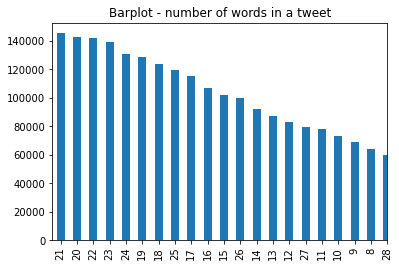

In [21]:
lenghts = data.text.apply(lambda x: len(x.split()))

print('Max numbers of words in a tweet:', max(lenghts))
print('Min numbers of words in a tweet:', min(lenghts))
print('Mean numbers of words in a tweet:', round(np.mean(lenghts),2))

import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot()
lenghts.value_counts().plot(kind = 'bar', ax = ax)
plt.title('Barplot - number of words in a tweet')
ax.set_xlim(-0.5,20)
plt.show()

# After preprocessing of the text

Dataset after removing the links, numbers, mentions, emoticons etc. and keeping only nouns, verbs, adverbs and adjectives

In [18]:
data_new = pd.read_csv('twcs_better.csv', sep = ',')

In [20]:
data_new.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,clean_text,lemma_text
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3.0,i understand i would like to assist you we would need to get you into a private secured link to further assist,"['understand', 'like', 'assist', 'need', 'get', 'private', 'secure', 'link', 'far', 'assist']"
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,and how do you propose we do that,"['how', 'propose', 'do']"
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4.0,i have sent several private messages and no one is responding as usual,"['send', 'several', 'private', 'message', 'one', 'respond', 'usual']"
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5.0,please send us a private message so that we can further assist you just click message at the top of your profile,"['send', 'private', 'message', 'far', 'assist', 'just', 'click', 'message', 'top', 'profile']"
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,i did,['do']


In [40]:
def lemma(text):
    words = []
    text = re.sub('\]|\[|\,|\'', '', text)
    text = re.sub('\\\\ud200', '', text)
    text = re.sub('。', '', text)
    for i in text.split():
        if i:
            words.append(i)
    return words

In [41]:
data_new['lemma_text_new'] = data_new["lemma_text"].apply(lambda x: lemma(x))

Max numbers of words in a tweet: 105
Min numbers of words in a tweet: 0
Mean numbers of words in a tweet: 8.8


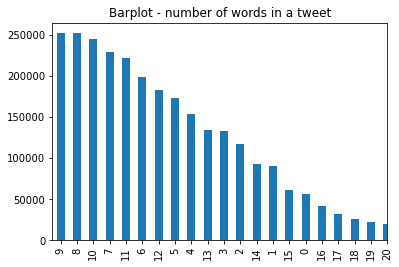

In [55]:
lenghts = data_new.lemma_text_new.apply(lambda x: len(x))

print('Max numbers of words in a tweet:', max(lenghts))
print('Min numbers of words in a tweet:', min(lenghts))
print('Mean numbers of words in a tweet:', round(np.mean(lenghts),2))

import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot()
lenghts.value_counts().plot(kind = 'bar', ax = ax)
plt.title('Barplot - number of words in a tweet')
ax.set_xlim(-0.5,20)
plt.show()

In [46]:
dictionary = gensim.corpora.Dictionary(data_new['lemma_text_new'])
dictionary.filter_extremes(no_below=500, no_above=0.7)

Most common words in dataset - **remove** be, have, do, so,m... because they do not add meaning to the topic

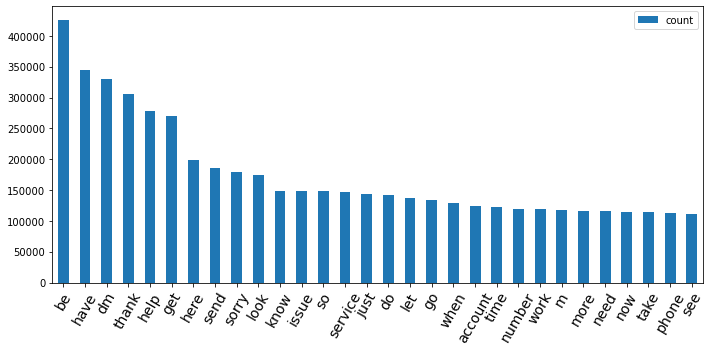

In [47]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']
cleansed_words_df.sort_values('count', ascending=False, inplace=True)
cleansed_words_df.iloc[0:30].plot(kind = 'bar', rot=60, figsize=(10,5))
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()

In [75]:
my_stop_words = STOPWORDS.union(set(['do', 'so', 'be', 'go', 'i', 'm', 're', 'have','why', 'when', 'how', 're', 'then', 's', 'get', 'try',
                                    'e', 'aa', 'fuck', 'r', 'fucking', ]))

# Removal of companies

In [49]:
dictionary_authors = gensim.corpora.Dictionary(data_new.loc[data.author_id.str.isnumeric() == False,'lemma_text_new'])

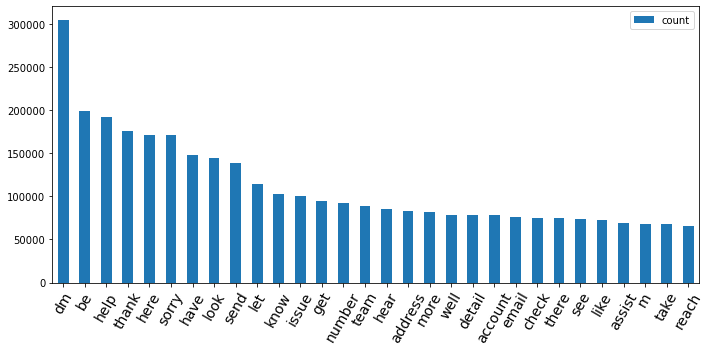

In [53]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary_authors.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary_authors.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']
cleansed_words_df.sort_values('count', ascending=False, inplace=True)
cleansed_words_df.iloc[0:30].plot(kind = 'bar', rot=60, figsize=(10,5))
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()

Responses from companies are mostly generic - most common words are DM, be, help, send, sorry- they don't add any meaning to the topics - better determining of the user's problems if companies are left out